# Visualize cot-cpt-rfo scatter plot s.t.
```
Simplified ISCCP cloud regimes for evaluating cloudiness in CMIP5 models
```

In [1]:
%matplotlib inline
import os
import gc
import re
import glob
import scipy
import numpy as np
import pandas as pd
import netCDF4
import pickle
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
from matplotlib.backends.backend_pdf import PdfPages

In [3]:
import matplotlib.ticker as mticker

In [4]:
from adjustText import adjust_text

In [5]:
def pkl_reader(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    return data

-------------------------
## V3. Combine eight figures into one figure

In [7]:
year='2003'
expname='10021600'
# label days
lsday=1
_leday=195
layer_name = 'leaky_re_lu_21'

In [8]:
outputdir = '/home/tkurihana/modis-climate/anl/output'

In [9]:
all_results = {}

In [10]:
for sday, _eday, month in zip([1, 182],[15,195], ['jan', 'july'] ):
    results = dict()
    labels  = dict()
    moments = dict()

    outputdir = '/home/tkurihana/modis-climate/anl/output'
    ctimestamp = '2003-015-105-195-288_053-132-185-315'
    nclusters =  [10,42, 64, 256]
    for ncluster in nclusters:
        
        if nclusters == 42: 
            if sday == 1:
                eday = 31
            elif sday == 182:
                eday = 212
        
        else:
            leday = _leday
            eday = _eday
        
        try:
            # three comp
            avg_array = np.load(f"{outputdir}/outputs/{ctimestamp}/calc_param-2003-{sday}-{eday}-{ncluster}.npy",
                            allow_pickle=True)
        
            # histo
            #avg_array = np.load(f"{outputdir}/outputs/{ctimestamp}/calc_param-2003-{lsday}-{leday}-{ncluster}.npy",
            #            allow_pickle=True)
        except Exception as e:
            avg_array = None
            print(f'error parameter: {e}')
            pass
        results[ncluster] = avg_array # (#nclusters, 2): (1) cot, (2) ctp
        #
        try:
            #data = pkl_reader(f'{outputdir}/outputs/{ctimestamp}/rfos-2003-{sday}-{eday}-{ncluster}.pkl')
            data = pkl_reader(f'{outputdir}/outputs/{ctimestamp}/rfos-2003-{lsday}-{leday}-{ncluster}.pkl')
            cluster_freq = data['cfreq']
        except Exception as e:
            print(f'error RFO: {e}')
            pass
        labels[ncluster] = cluster_freq
        #
        try:
            ## colored histogram
            #mom_array = np.load(f"{outputdir}/outputs/{ctimestamp}/calc_moment-2003-{sday}-{eday}-{ncluster}.npy",
            #                allow_pickle=True)
            ## three dim figures
            mom_array = np.load(f"{outputdir}/outputs/{ctimestamp}/calc_moment-2003-{lsday}-{leday}-{ncluster}.npy",
                            allow_pickle=True)
        except Exception as e:
            print(f'error RFO: {e}')
            pass
        moments[ncluster] = mom_array
    
    # summary
    all_results[month] = {'avg':results, 'labels':labels, 'moments':moments}

#### relabels

In [11]:
# cluster range 1 -- N+1
# cluster range 1 -- N+1
relabels = {}
for nclusters in [10,42,64,256]:
    df = pd.read_csv(f"./csvs/sort_cot-ctp_means-{nclusters}.csv", index_col=0)
    tmp = {}
    for ic, ric in zip(df['cluster'], df['rcluster']):
        tmp[ic] = ric
    relabels[nclusters] = tmp

#### Configs

In [14]:
#figsize=(12*4+4,8*2+2)
#figsize=(8*4+8,6*2+4)
figsize=(8*4+8,6*2+4)
cmap='brg'
dy=0
alpha=0.7
flag_save=True #True
PDF=True
savefigdir='./figs'
hxmin=0.002
hxmax=60 #60.0
flag_adjust=True
limit_annotate=False
thres_annotate=0.75
adjust_fp=0
arrow=False 
fyl=35 #  16
fts=45 #16
ftp=32 # param tciks
tick_font_size = 33

### isccp delineators
hlw=vlw=3


### subtitle
pos_sx = hxmin*1.25
pos_sy = 220
font_scale=52

In [15]:
# ax
nrow=2
ncol=4

# gs
#nstep=8
#nrow=nstep*2+1
#ncol=nstep*4+4+1

In [16]:
position=[0.9, 0.25, 10, 10] # [left, bottom, width, height]

In [17]:
len(np.argwhere(np.ones((10)) == 1) )

10

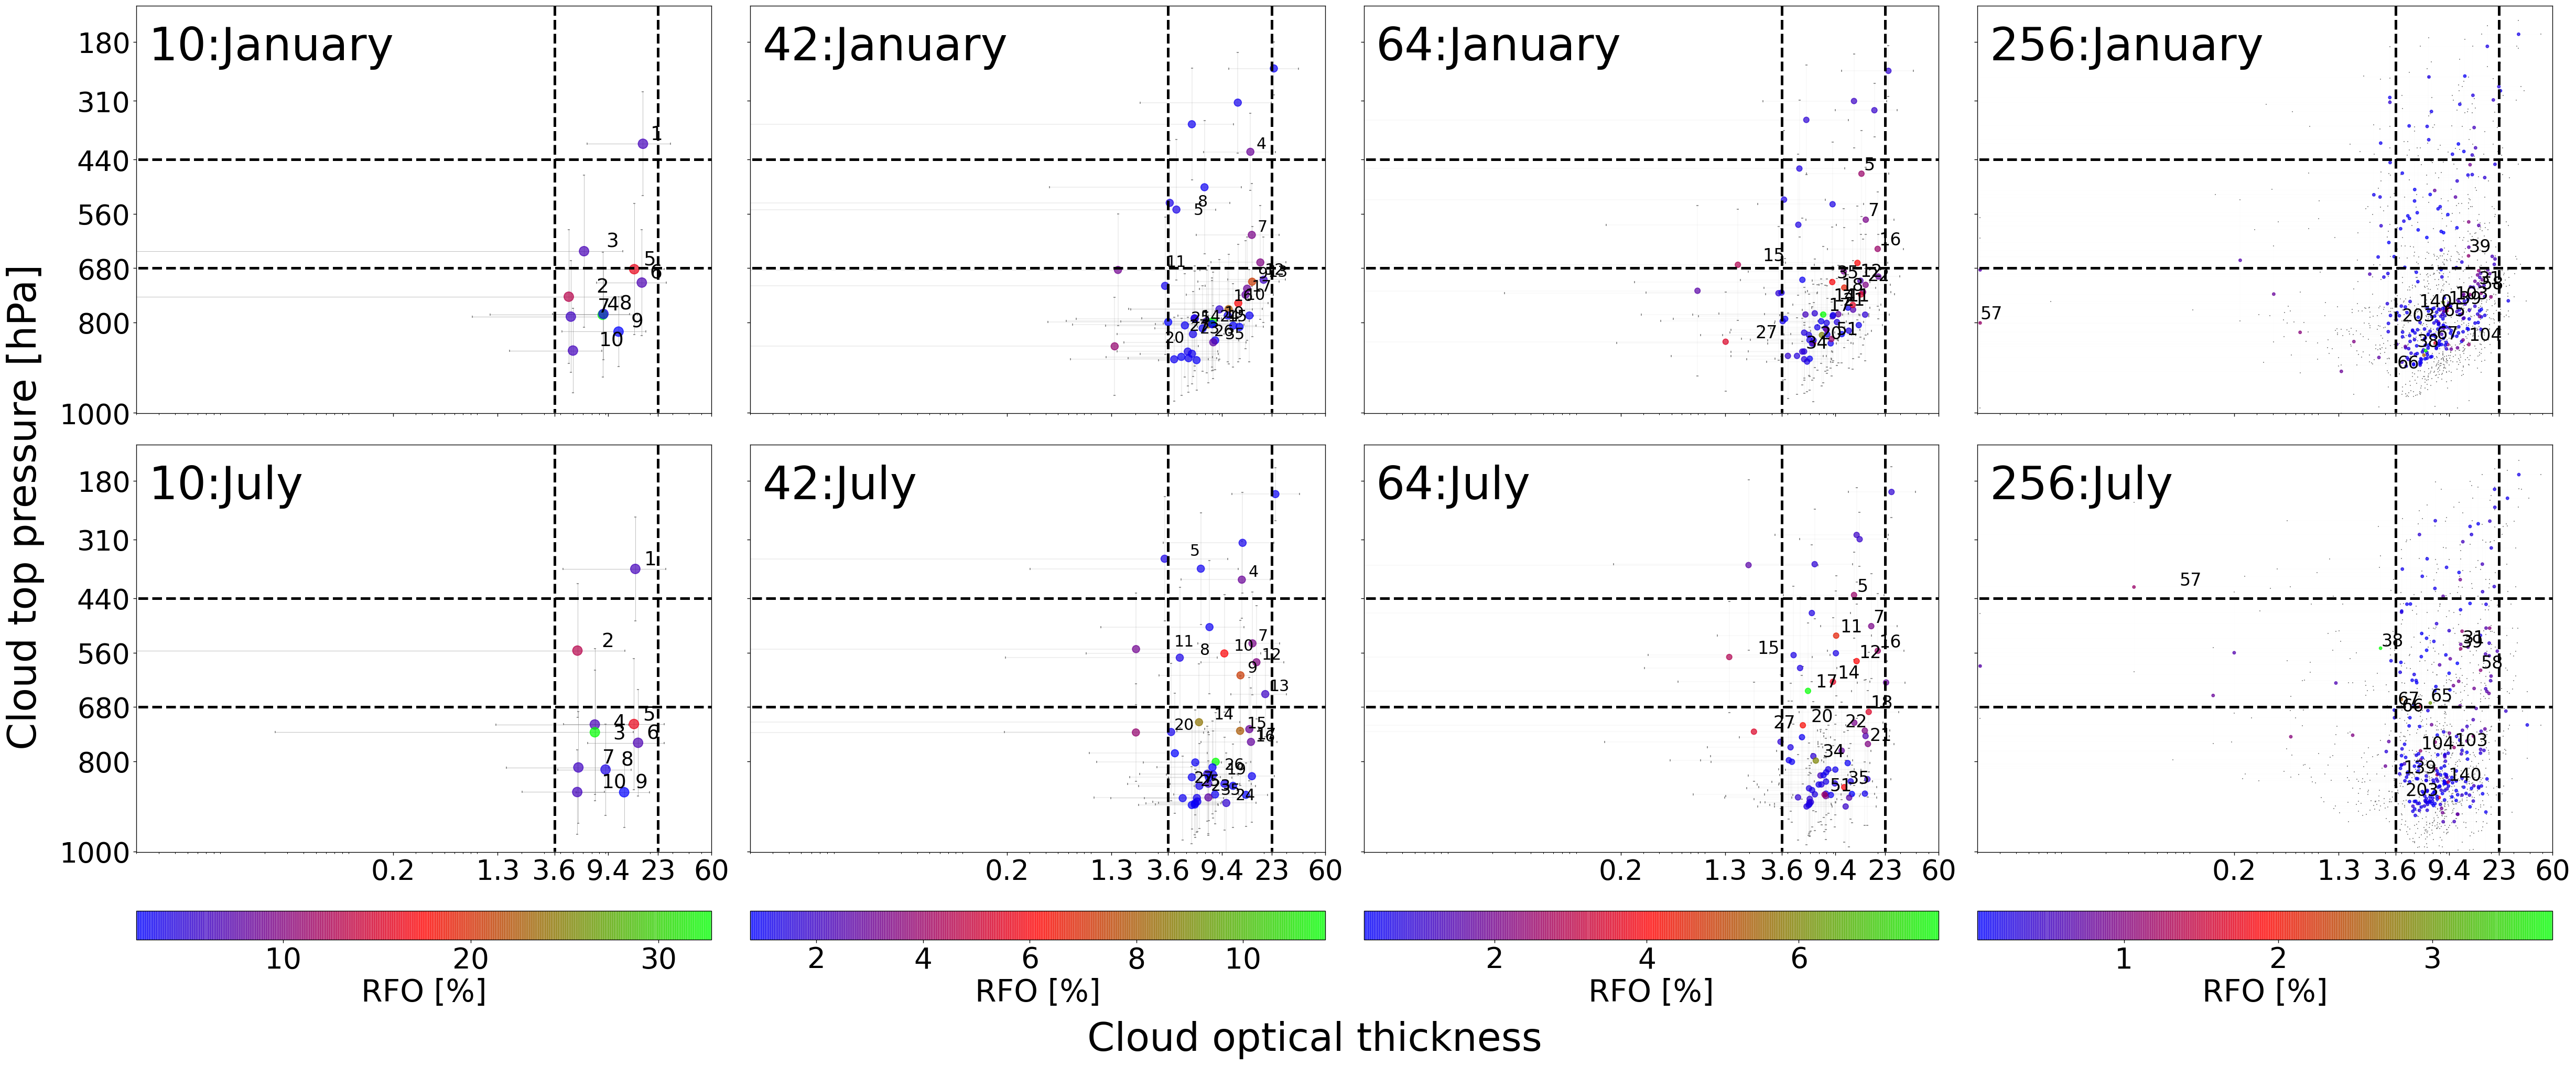

In [19]:
#fig = plt.figure(figsize=figsize)
#gs0 = gridspec.GridSpec(nrow, ncol, figure=fig)
fig, axs = plt.subplots(nrow, ncol, figsize=figsize, constrained_layout=True,dpi=120) #sharex=True, sharey=True,
tex_x_pos = {}


for col_idx, (ncluster, limit_annotate, thres_annotate, ew, caps, arrow,ss, ftex) in enumerate(
                                zip([10,42,64,256], 
                                    [False, True, True, True],[1,0.5,0.75, 0.95],
                                    [0.3,0.15,0.05,0.01],
                                    [1, 1, 1, 0.5],
                                    [False, False, False, False],
                                    [120,70,40,10],
                                    [15*1.5, 10*1.8, 10*2, 8*2.5]
                                    )):
    #for month, result_dicts in all_results.items():
    for row_idx, month in  enumerate(['jan', 'july']) :
        
        # axis
        ax = axs[row_idx, col_idx]
        #print(row_idx*nstep,(row_idx+1)*nstep, col_idx*nstep+col_idx,(col_idx+1)*nstep+col_idx,(col_idx+1)*nstep+col_idx+1)
        #ax = fig.add_subplot(gs0[row_idx*nstep:(row_idx+1)*nstep, col_idx*nstep+col_idx:(col_idx+1)*nstep+col_idx])
        
        #####################################
        result_dicts = all_results[month]
        # get data
        results = result_dicts['avg']
        moments = result_dicts['moments']
        labels  = result_dicts['labels']
    
        # position
        tex_x_pos[ncluster] = np.array([ i for i in results[ncluster][:,0]  ])
        
        # unroll
        opts =  results[ncluster][:,0] 
        eopts = moments[ncluster][:,0]
    
        zero_idx = np.where(opts == 0)
        if len(zero_idx) > 0:
            opts[zero_idx] += hxmin+0.0001
    
        if ew > 0:
            ax.errorbar(opts, results[ncluster][:,1],
                         xerr= eopts, yerr= moments[ncluster][:,1], 
                         ls='none', color='grey', elinewidth=ew,capsize=caps,zorder=-32)
        sc = ax.scatter( opts, results[ncluster][:,1],s=ss,c=labels[ncluster], cmap=cmap, alpha=alpha )
    
        # limit annotate data
        if limit_annotate:
            # + 1 for index to align with the range from (1,ncluster)
            selected_clusters = np.where( 
                labels[ncluster] >= np.quantile(labels[ncluster], thres_annotate))[0] + 1
        else:
            selected_clusters = np.arange(1,ncluster+1,1)
    
        # text annotation
        texts = []
        xas, yas = [], []
        for ic, ix, iy in zip(np.arange(1,ncluster+1,1),tex_x_pos[ncluster], results[ncluster][:,1]):
            if ic in selected_clusters:
                ric = relabels[ncluster][ic]
                texts.append(ax.text(ix, iy, f'{ric}', fontsize=ftex))

        #else:
        if flag_adjust:
            adjust_text(texts,ha='center', va='bottom') # 
            
        # y axis
        ax.set_ylim(100,1001)
        ax.set_yticks([180, 310,440,560, 680, 800, 1000])
        if col_idx == 0:
            ax.set_yticklabels([180, 310,440,560, 680, 800, 1000])
        else:
            ax.set_yticklabels([])
        
        ax.invert_yaxis()
        # x axis
        ax.set_xscale('log')
        ax.set_xlim(hxmin,hxmax)
        ax.xaxis.set_major_formatter(mticker.NullFormatter())
        ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
        
        ax.set_xticks([ i for i in [0.2, 1.3, 3.6, 9.4, 23, hxmax]])
        if row_idx == 1:
            ax.set_xticklabels([ str(i) for i in [0.2, 1.3, 3.6, 9.4, 23, hxmax]],  
                            )
        else:
            ax.set_xticklabels([])
    
        # v.2
        ax.hlines( 440, 0, hxmax, color='black', linestyle='--', linewidth=hlw)
        ax.hlines( 680, 0, hxmax, color='black', linestyle='--', linewidth=hlw)
        # vline
        ax.vlines(23, 100, 1000, color='black', linestyle='--',  linewidth=vlw)
        ax.vlines(3.6, 100, 1000, color='black', linestyle='--', linewidth=vlw )
    
        # size
        ax.tick_params(axis='both', labelsize=ftp)
    
        # subtitle to each 
        str_month = "January" if month == 'jan' else "July"
        ax.text(pos_sx, pos_sy,f"{ncluster}:{str_month}", fontsize=font_scale )
    
    
    # colorbar
    cbar = fig.colorbar(sc, ax=[axs[-1,col_idx]],orientation='horizontal', aspect=8)
    cbar.ax.set_xlabel('RFO [%]', fontsize=fyl)
    cbar.ax.tick_params(labelsize=tick_font_size)


fig.text(0.5, -0.04, 'Cloud optical thickness', fontsize=fts, ha='center')
fig.text(-0.02, 0.5, 'Cloud top pressure [hPa]', fontsize=fts, va='center', rotation='vertical')
#fig.subplots_adjust(wspace=0.1)
#plt.show()
if flag_save:
        if PDF:
            #pdf = PdfPages(os.path.join(savefigdir, f'COT-CPT-RFO_{month}-{ncluster}.pdf') )
            pdf = PdfPages(os.path.join(savefigdir, f'COT-CPT-RFO_jan-july_MDPI.pdf') )
            plt.savefig(pdf, format='pdf', bbox_inches = 'tight')
            pdf.close()
            pdf = None
        else:
            plt.savefig(os.path.join(savefigdir, f'COT-CPT-RFO_{month}-{ncluster}.png'))
else:
    plt.show()
    plt.close()

---------------
## V3 Heatmap histogram

In [6]:
year='2003'
expname='10021600'
# label days
lsday=1
_leday=195
layer_name = 'leaky_re_lu_21'

In [7]:
outputdir = '/home/tkurihana/modis-climate/anl/output'

In [8]:
all_results = {}

In [9]:
for sday, _eday, month in zip([1],[195], ['jan-july'] ):
    results = dict()
    labels  = dict()
    moments = dict()

    outputdir = '/home/tkurihana/modis-climate/anl/output'
    ctimestamp = '2003-015-105-195-288_053-132-185-315'
    nclusters =  [10,42, 64, 256]
    for ncluster in nclusters:
        
        if nclusters == 42: 
            if sday == 1:
                #eday = 31
                eday = 212
            #elif sday == 182:
            #    eday = 212
        
        else:
            leday = _leday
            eday = _eday
        
        try:
            # three comp
            #avg_array = np.load(f"{outputdir}/outputs/{ctimestamp}/calc_param-2003-{sday}-{eday}-{ncluster}.npy",
            #                allow_pickle=True)
        
            # histo
            avg_array = np.load(f"{outputdir}/outputs/{ctimestamp}/calc_param-2003-{lsday}-{leday}-{ncluster}.npy",
                        allow_pickle=True)
        except Exception as e:
            avg_array = None
            print(f'error parameter: {e}')
            pass
        results[ncluster] = avg_array # (#nclusters, 2): (1) cot, (2) ctp
        #
        try:
            #data = pkl_reader(f'{outputdir}/outputs/{ctimestamp}/rfos-2003-{sday}-{eday}-{ncluster}.pkl')
            data = pkl_reader(f'{outputdir}/outputs/{ctimestamp}/rfos-2003-{lsday}-{leday}-{ncluster}.pkl')
            cluster_freq = data['cfreq']
        except Exception as e:
            print(f'error RFO: {e}')
            pass
        labels[ncluster] = cluster_freq
        #
        try:
            ## colored histogram
            mom_array = np.load(f"{outputdir}/outputs/{ctimestamp}/calc_moment-2003-{sday}-{eday}-{ncluster}.npy",
                            allow_pickle=True)
            ## three dim figures
            #mom_array = np.load(f"{outputdir}/outputs/{ctimestamp}/calc_moment-2003-{lsday}-{leday}-{ncluster}.npy",
            #                allow_pickle=True)
        except Exception as e:
            print(f'error RFO: {e}')
            pass
        moments[ncluster] = mom_array
    
    # summary
    all_results[month] = {'avg':results, 'labels':labels, 'moments':moments}

#### Configs

In [10]:
figsize= (12*4+4,10*1+2) #(12*4+8,12*1+4)
mycmap='nipy_spectral'
flag_save=True
PDF=True
savefigdir='./figs'
hxmin=0.002
hxmax=60 #60.0
thres=0.0001
pvmin=0
pvmax=67
ftex = 24
fyl=55 #35 #  16
#fts=45 #16
fts=65 #55 #16
ftp=32 # param tciks
fcl = tick_font_size = 45 #33
lw=4.5
month='Jan-July'

# font scale
font_scale=65
alphabets = {0:'a', 1: 'b', 2: 'c',3: 'd'}

In [11]:
# ax
nrow=1
ncol=4

#### Plot

<ipython-input-15-3158549f2c04>:3: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0)
<ipython-input-15-3158549f2c04>:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm = ax.pcolormesh(x,y,myhist,cmap=mycmap,vmin=pvmin,vmax=pvmax,rasterized=True)


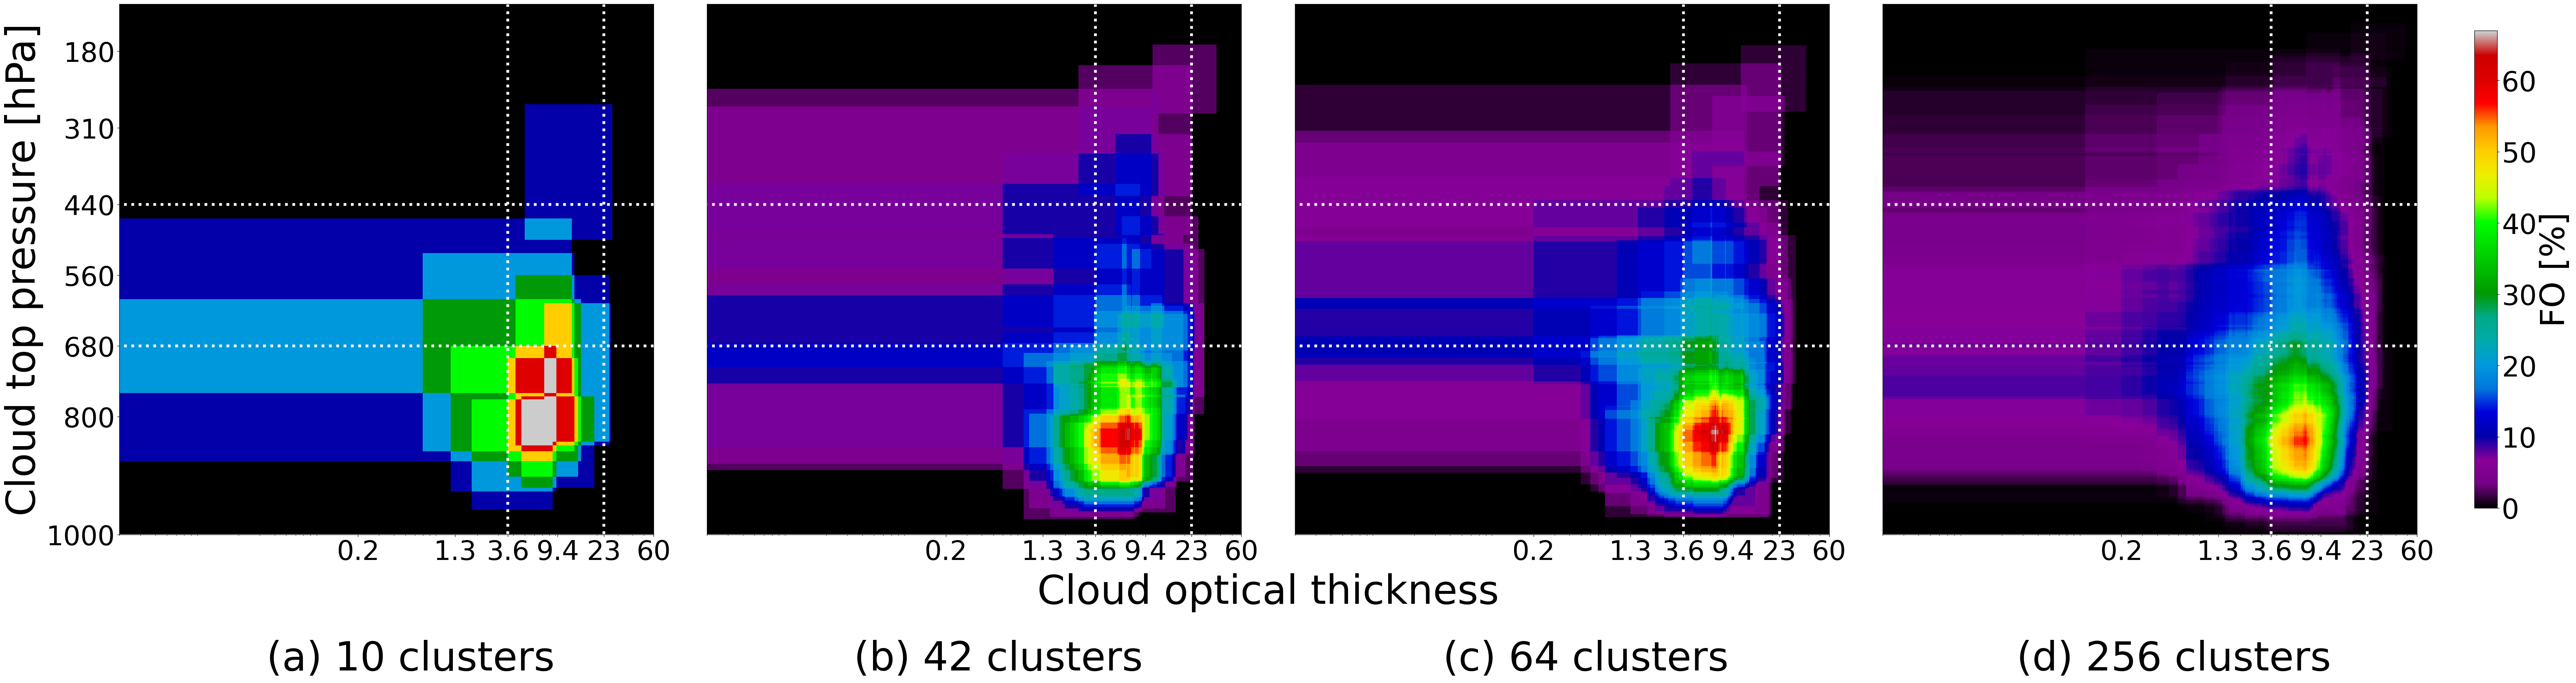

In [15]:
#fig = plt.figure(figsize=figsize )
fig, axs = plt.subplots(nrow, ncol, figsize=figsize, constrained_layout=True,dpi=120) #sharex=True, sharey=True,
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0)
tex_x_pos = {}
matplotlib.rcParams.update({'font.size': 44})
    
row_idx=0
for col_idx, nclusters in enumerate([10,42,64,256]): 
    
    results = all_results['jan-july']['avg']
    moments = all_results['jan-july']['moments']
    myhist = gen_heatmap_array(results[nclusters], moments[nclusters])
    
    # axis
    ax = axs[col_idx]
    
    #ax = plt.subplot(111)
    x = np.arange(0,60.0,0.1)
    y = np.arange(0,1000)

    # mask
    #myhist = np.ma.masked_where(myhist < thres, myhist)
    # set cmap
    #_cmap = matplotlib.cm.get_cmap(mycmap) #.copy()
    #_cmap.set_bad(color='white')
    
    # show
    pcm = ax.pcolormesh(x,y,myhist,cmap=mycmap,vmin=pvmin,vmax=pvmax,rasterized=True)
    ax.set_xlim(hxmin,60)
    ax.invert_yaxis()
    ax.set_ylim(1000,100)
    ax.set_xscale('log')

    # hline
    ax.hlines( 440, 0, 60, color='white', linestyle=':', linewidth=lw)
    ax.hlines( 680, 0, 60, color='white', linestyle=':', linewidth=lw)
    # vline
    ax.vlines(23, 100, 1000, color='white', linestyle=':', linewidth=lw)
    ax.vlines(3.6, 100, 1000, color='white', linestyle=':',  linewidth=lw)

    #plt.yscale('log')
    ax.set_xticks(np.array([0.2, 1.3, 3.6, 9.4, 23, 60,]))
    ax.set_xticklabels(
            labels=[ str(i) for i in [0.2, 1.3, 3.6, 9.4, 23, 60,]],
          )
    if col_idx == 0:

        ax.set_yticks(np.array([180, 310,440,560, 680, 800, 1000]))
        ax.set_yticklabels(
            labels=[ str(i) for i in [180, 310,440,560, 680, 800, 1000]],
            )
    else:
        #ax.set_xticks([])
        ax.set_yticks([])
    
    alphabet = alphabets[col_idx]
    ax.text(0.55, 1230, f'({alphabet}) {nclusters} clusters', fontsize=font_scale, ha='center')
        
    #plt.colorbar()
    #if ncluster ==256:
    #    cbaxes = fig.add_axes([0.95, 0.12, 0.03, 0.76]) 
    #    cbar = fig.colorbar(pcm, cax = cbaxes)
    #    cbar.ax.tick_params(labelsize=fcl)
    #    cbar.ax.set_ylabel('RFO [%]', fontsize=fyl)
        
        
cbar_ax = fig.add_axes([1.025, 0.05, 0.01, 0.9]) #[left, bottom, width, height], [0.9, 0.25, 10, 10]
cbar = fig.colorbar(pcm, cax=cbar_ax) 
cbar.ax.set_ylabel('FO [%]', fontsize=fyl)
cbar.ax.tick_params(labelsize=tick_font_size)
        
# label
fig.text(0.5, -0.13, 'Cloud optical thickness', fontsize=fts, ha='center')
fig.text(-0.05, 0.5, 'Cloud top pressure [hPa]', fontsize=fts, va='center', rotation='vertical')

plt.subplots_adjust(wspace=0.1)

#fig.tight_layout()
# SHOW
#plt.show()
if flag_save:
        if PDF:
            pdf = PdfPages(os.path.join(savefigdir, f'2DHIST-COT-CPT-FO_{month}.pdf') )
            plt.savefig(pdf, format='pdf', bbox_inches = 'tight')
            pdf.close()
            pdf = None
        else:
            plt.savefig(os.path.join(savefigdir, f'2DHIST-COT-CPT-FO_{month}.png'))
plt.show()
plt.close()